In [24]:
import torch 
torch.random.manual_seed(11)

import numpy as np 
np.random.seed(11)
import matplotlib.pyplot as plt 
import time

In this tutorial, we extend the first tutorial to a full navigation example. The principle of BRNE stays the same: it takes two initial probability distributions that represent the agents' preferences, then calculates the Nash equilibrium distributions as the optimal ''compromise'' from the agents. 

The difference here is that, the decision making space is no longer a 2D plane, but the space of trajectories--sequences of states over the planning horizon. This introduces two necessary changes:

1. Not all sequences of states are physically feasible for embodied agents (humans or robots) to execute, so we need to define the preference over feasible trajectories. Here, we choose to model the preferences as a Gaussian process. More details of Gaussian processes can be found in this [classic textbook](https://gaussianprocess.org/gpml/). 

2. Trajectories are high-dimensional, which means maintaining a discrete grid-based representation of the distribution as in the first tutorial is no longer computationally feaisble. As a result, we are going to use samples to approximate the distribution, and apply the techinique of importance sampling (assigning uneven weights to samples) to represent the Nash equilirbium distributions.

In [3]:
# We first generat the configurations of the navigation task, where do the agents start and what are their goals.

circle_radius = 3.0 
num_agents = 2
min_dist = 1.0

angle_1 = np.random.uniform(-np.pi, np.pi)
init_1 = np.array([
    np.cos(angle_1), np.sin(angle_1)
]) * circle_radius
goal_1 = -1.0 * init_1 

while True:
    angle_2 = np.random.uniform(-np.pi, np.pi)
    init_2 = np.array([
        np.cos(angle_2), np.sin(angle_2)
    ]) * circle_radius
    goal_2 = -1.0 * init_2
    
    dist = np.linalg.norm(init_2 - init_1)
    if dist > min_dist:
        break

In [5]:
# Now we configure Gaussian processes as the preference for each agent

class GP:
    def __init__(self, 
                 dt: float,
                 tsteps: float,
                 kernel_a1: float,
                 kernel_a2: float) -> None:
        self.kernel_a1 = kernel_a1 
        self.kernel_a2 = kernel_a2
        self.Lcov_mat = self.get_Lcov(tsteps, dt)

        self.tsteps = tsteps 
        self.dt = dt

    def kernel(self,
               t1: torch.Tensor,
               t2: torch.Tensor):
        return torch.exp(-self.kernel_a1 * (t1-t2)**2) * self.kernel_a2
    
    def get_Lcov(self, 
                 tsteps: int, 
                 dt: float):
        time_list_1 = torch.tensor([0.0, (tsteps-1)*dt])
        time_list_2 = torch.arange(tsteps) * dt
        
        mat_11 = torch.vmap(self.kernel, in_dims=(0,None))(time_list_1, time_list_1)
        mat_12 = torch.vmap(self.kernel, in_dims=(0,None))(time_list_1, time_list_2)
        mat_22 = torch.vmap(self.kernel, in_dims=(0,None))(time_list_2, time_list_2)
        
        full_mat = mat_22 - mat_12.T @ torch.inverse(mat_11) @ mat_12
        full_mat += torch.eye(tsteps) * 1e-04
        return torch.linalg.cholesky(full_mat)

    def mvn_sampling(self,
                     num_samples: int):
        init_samples = torch.randn(size=(self.Lcov_mat.shape[0], num_samples))
        new_samples = self.Lcov_mat @ init_samples
        return new_samples.T
    
    def generate_samples(self,
                         traj_1: torch.Tensor,
                         traj_2: torch.Tensor,
                         num_samples: int):        
        traj_x_samples_1 = self.mvn_sampling(num_samples) + traj_1[:,0]
        traj_y_samples_1 = self.mvn_sampling(num_samples) + traj_1[:,1]
        traj_samples_1 = torch.stack([traj_x_samples_1, traj_y_samples_1])
        traj_samples_1 = torch.transpose(traj_samples_1, 0, 1)
        traj_samples_1 = torch.transpose(traj_samples_1, 1, 2)

        traj_x_samples_2 = self.mvn_sampling(num_samples) + traj_2[:,0]
        traj_y_samples_2 = self.mvn_sampling(num_samples) + traj_2[:,1]
        traj_samples_2 = torch.stack([traj_x_samples_2, traj_y_samples_2])
        traj_samples_2 = torch.transpose(traj_samples_2, 0, 1)
        traj_samples_2 = torch.transpose(traj_samples_2, 1, 2)

        return traj_samples_1, traj_samples_2

In [7]:
dt = 0.3 
tsteps = 20
num_samples = 200 
num_iters = 20

kernel_a1 = 0.03
kernel_a2 = 5.0

gp_pref = GP(dt=dt, tsteps=tsteps, kernel_a1=kernel_a1, kernel_a2=kernel_a2)

In [8]:
# We also need to define the risk funtion between two trajectories
# Here we first define a 2D Gaussian as the risk between two states in the 2D plan
# Then we evaluate this function over all the corresponding time steps between two trajectories, 
# ... and calculate the mean as the risk between the two trajectories.
# Again, the algorithm works with arbitrary choice of risk functions.

risk_cov = np.diag(np.random.uniform(low=0.3, high=0.8, size=2)) * 0.5
risk_cov[0,1] = np.sqrt(np.prod(np.diagonal(risk_cov))) / 2.0
risk_cov[1,0] = risk_cov[0,1]
risk_cov = torch.tensor(risk_cov, dtype=torch.float32)
risk_cov_inv = torch.linalg.inv(risk_cov)
risk_eta = 1.0 / torch.sqrt((2.0*torch.pi)**2 * torch.linalg.det(risk_cov))
def risk_traj(traj1, traj2):
    d_traj = traj1 - traj2
    vals = torch.exp(-0.5 * torch.sum(d_traj @ risk_cov_inv * d_traj, dim=1)) * 200.0
    return torch.mean(vals)

In [15]:
# We generate the initial preference for each agent and draw trajectory samples from it

traj_1 = torch.tensor(np.linspace(init_1, goal_1, tsteps), dtype=torch.float32)
weights_1 = torch.ones(num_samples)
traj_2 = torch.tensor(np.linspace(init_2, goal_2, tsteps), dtype=torch.float32)
weights_2 = torch.ones(num_samples)

traj_samples_1, traj_samples_2 = gp_pref.generate_samples(traj_1, traj_2, num_samples)

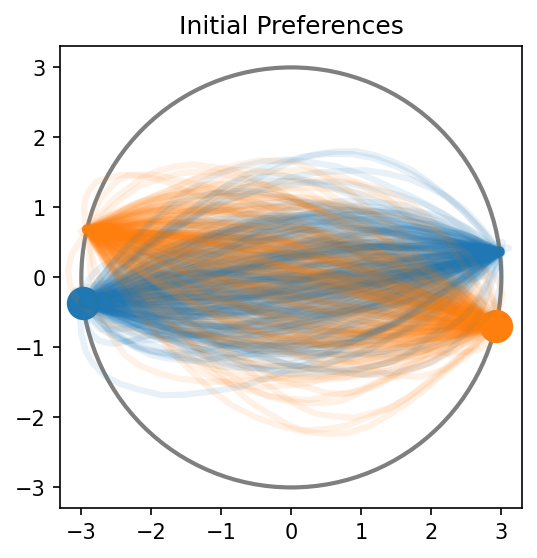

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=150)
ax.set_title('Initial Preferences')
ax.set_xlim(-1.1*circle_radius, 1.1*circle_radius)
ax.set_ylim(-1.1*circle_radius, 1.1*circle_radius)
ax.set_aspect('equal')

circle = plt.Circle((0.0, 0.0), circle_radius, fill=False, color='k', linewidth=2, alpha=0.5)
ax.add_patch(circle)

traj_1_np = traj_1.cpu().numpy()
traj_2_np = traj_2.cpu().numpy()
ax.plot(traj_1_np[0,0], traj_1_np[0,1], marker='o', markersize=15, color='C0')
ax.plot(traj_2_np[0,0], traj_2_np[0,1], marker='o', markersize=15, color='C1')

traj_samples_1_np = traj_samples_1.cpu().numpy()
traj_samples_2_np = traj_samples_2.cpu().numpy()
for traj_1_i, traj_2_i in zip(traj_samples_1_np, traj_samples_2_np):
    ax.plot(traj_1_i[:,0], traj_1_i[:,1], linestyle='-', linewidth=3, color='C0', alpha=0.1)
    ax.plot(traj_2_i[:,0], traj_2_i[:,1], linestyle='-', linewidth=3, color='C1', alpha=0.1)

plt.show()
plt.close()

In [25]:
# We now run the BRNE algorithm
tic = time.time()
risk_table = torch.vmap(torch.vmap(risk_traj, in_dims=(None,0)), in_dims=(0,None))(
    traj_samples_1, traj_samples_2
)

for _ in range(num_iters):
    risk_2to1 = torch.mean(risk_table * weights_2, dim=1)
    new_weights_1 = torch.exp(-1.0 * risk_2to1)
    new_weights_1 /= torch.mean(new_weights_1)

    risk_1to2 = torch.mean(risk_table * new_weights_1[:,None], dim=0)
    new_weights_2 = torch.exp(-1.0 * risk_1to2)
    new_weights_2 /= torch.mean(new_weights_2)

    weights_1 = new_weights_1
    weights_2 = new_weights_2

# Calculate the weighted mean as the optimal trajectories
opt_traj_1 = torch.mean(traj_samples_1 * weights_1.view(-1, 1, 1), dim=0)
opt_traj_2 = torch.mean(traj_samples_2 * weights_2.view(-1, 1, 1), dim=0)

toc = time.time()
print(f'elapsed time after [{num_iters}] iterations: {toc-tic:.4f} s')

elapsed time after [20] iterations: 0.0285 s


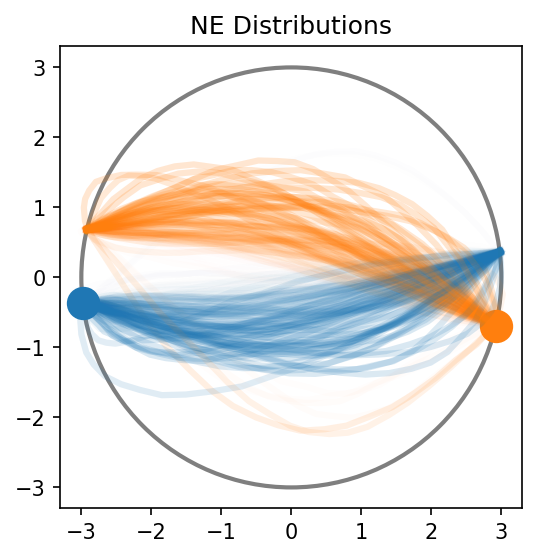

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=150)
ax.set_title('NE Distributions')
ax.set_xlim(-1.1*circle_radius, 1.1*circle_radius)
ax.set_ylim(-1.1*circle_radius, 1.1*circle_radius)
ax.set_aspect('equal')

circle = plt.Circle((0.0, 0.0), circle_radius, fill=False, color='k', linewidth=2, alpha=0.5)
ax.add_patch(circle)

traj_1_np = traj_1.cpu().numpy()
traj_2_np = traj_2.cpu().numpy()
ax.plot(traj_1_np[0,0], traj_1_np[0,1], marker='o', markersize=15, color='C0')
ax.plot(traj_2_np[0,0], traj_2_np[0,1], marker='o', markersize=15, color='C1')

traj_samples_1_np = traj_samples_1.cpu().numpy()
traj_samples_2_np = traj_samples_2.cpu().numpy()
weights_1_np = weights_1.cpu().numpy()
weights_2_np = weights_2.cpu().numpy()
for traj_1_i, traj_2_i, w1, w2 in zip(traj_samples_1_np, traj_samples_2_np, weights_1_np, weights_2_np):
    ax.plot(traj_1_i[:,0], traj_1_i[:,1], linestyle='-', linewidth=3, color='C0', alpha=0.05*w1)
    ax.plot(traj_2_i[:,0], traj_2_i[:,1], linestyle='-', linewidth=3, color='C1', alpha=0.05*w2)
    
plt.show()
plt.close()

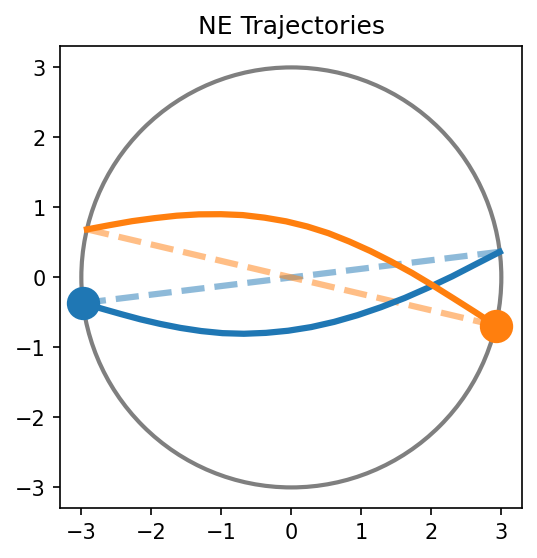

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=150)
ax.set_title('NE Trajectories')
ax.set_xlim(-1.1*circle_radius, 1.1*circle_radius)
ax.set_ylim(-1.1*circle_radius, 1.1*circle_radius)
ax.set_aspect('equal')

circle = plt.Circle((0.0, 0.0), circle_radius, fill=False, color='k', linewidth=2, alpha=0.5)
ax.add_patch(circle)

traj_1_np = traj_1.cpu().numpy()
traj_2_np = traj_2.cpu().numpy()
opt_traj_1_np = opt_traj_1.cpu().numpy()
opt_traj_2_np = opt_traj_2.cpu().numpy()
ax.plot(traj_1_np[0,0], traj_1_np[0,1], marker='o', markersize=15, color='C0')
ax.plot(traj_2_np[0,0], traj_2_np[0,1], marker='o', markersize=15, color='C1')
ax.plot(traj_1_np[:,0], traj_1_np[:,1], linestyle='--', linewidth=3, color='C0', alpha=0.5)
ax.plot(traj_2_np[:,0], traj_2_np[:,1], linestyle='--', linewidth=3, color='C1', alpha=0.5)
ax.plot(opt_traj_1_np[:,0], opt_traj_1_np[:,1], linestyle='-', linewidth=3, color='C0', alpha=1.0)
ax.plot(opt_traj_2_np[:,0], opt_traj_2_np[:,1], linestyle='-', linewidth=3, color='C1', alpha=1.0)

plt.show()
plt.close()